# OR4CLE – Minimal synthetic test notebook

This notebook runs a rolling experiment on the bundled synthetic dataset using the OR4CLE modules.

- Choose **BFM** or **BERM**
- Choose **observed** or **self-sustained** (counterfactual)
- Choose **GH** or **MC** inference
- Choose **prior family** and KS threshold

No figures are saved to disk; plots are shown inline.


In [1]:
# --- Configuration (edit only this cell) -------------------------------------

MODEL = "BFM"            # "BFM" or "BERM"
SELF_SUSTAINED = False   # True -> counterfactual/self-sustained
MODE = "gh"              # "gh" or "mc"

AGG = "monthly"          # synthetic dataset ships monthly labels

# Prior settings
if MODEL == "BFM":
    PRIOR_FAMILY = "gamma"    # BFM: "auto","gamma","lognormal","uniform"; BERM: "beta" (or "auto" if supported)
if MODEL == "BERM":
    PRIOR_FAMILY = "beta"    # BFM: "auto","gamma","lognormal","uniform"; BERM: "beta" (or "auto" if supported)
KS_ALPHA = 0.05

# Periods (labels are "YYYY-MM")
SEED_PERIOD     = ("2000-01", "2002-12")
ANALYSIS_PERIOD = ("2002-12", "2008-04")

# Rolling calibration window (in years). If None, uses the full available seed pool.
CAL_WINDOW_YEARS = 3

# Inference controls (only the relevant ones are used depending on MODE)
MC_SAMPLES = 4000
MC_BURNIN  = 500
MC_WIDTH   = 2.0

GH_NODES    = 25
GH_MAX_ITER = 60
GH_TOL      = 1e-10

RNG_SEED = 0

In [3]:
# --- Imports -----------------------------------------------------------------

import os, sys, json
import numpy as np
import matplotlib.pyplot as plt

# Add OR4CLE sources
SRC_DIR = os.path.abspath(os.path.join("..", "src", "or4cle"))
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

import BFM_solver
import BERM_solver
import prior_test
import utils

# Paths to the bundled synthetic dataset
DATA_ROOT = os.path.abspath(os.path.join("..", "datasets", "synthetic_networks"))
META_PATH = os.path.join(DATA_ROOT, "metadata.json")
SNAP_DIR  = os.path.join(DATA_ROOT, "snapshots")

meta = json.load(open(META_PATH, "r"))
snap_index = {d["label"]: d for d in meta["snapshots"]}
labels = [d["label"] for d in meta["snapshots"]]
print("Dataset:", meta.get("name", "synthetic_networks"), "| snapshots:", len(labels), "|", labels[0], "→", labels[-1])

Dataset: synthetic_networks_100 | snapshots: 100 | 2000-01 → 2008-04


In [4]:
# --- Minimal snapshot loader (no external loader module) ----------------------

def load_npz(label: str) -> np.lib.npyio.NpzFile:
    d = snap_index[label]
    return np.load(os.path.join(SNAP_DIR, d["file"]), allow_pickle=False)

def load_snapshot_bfm(label: str) -> BFM_solver.Snapshot:
    z = load_npz(label)
    return BFM_solver.Snapshot(
        A=z["A"].astype(np.float64),
        s=z["s"].astype(np.float64),
        node_ids=z["node_ids"].astype(np.int64),
    )

def load_snapshot_berm(label: str) -> BERM_solver.Snapshot:
    z = load_npz(label)
    return BERM_solver.Snapshot(
        A=z["A"].astype(np.float64),
        node_ids=z["node_ids"].astype(np.int64),
    )

In [5]:
# --- Instantiate rolling model -----------------------------------------------

UPDATE = "counterfactual" if SELF_SUSTAINED else "observed"
rng = np.random.default_rng(RNG_SEED)

if MODEL.upper() == "BFM":
    rm = BFM_solver.BFMRollingModel(
        agg=AGG,
        seed_period=SEED_PERIOD,
        analysis_period=ANALYSIS_PERIOD,
        loader=load_snapshot_bfm,
        prior_family=PRIOR_FAMILY,
        mode=MODE,
        update=UPDATE,
        cal_window_years=CAL_WINDOW_YEARS,
        rng=rng,
        mc_samples=MC_SAMPLES,
        mc_burnin=MC_BURNIN,
        mc_width=MC_WIDTH,
        gh_nodes=GH_NODES,
        gh_max_iter=GH_MAX_ITER,
        gh_tol=GH_TOL,
        return_Q=False,
        return_degrees=True,
    )
elif MODEL.upper() == "BERM":
    rm = BERM_solver.BERMRollingModel(
        agg=AGG,
        seed_period=SEED_PERIOD,
        analysis_period=ANALYSIS_PERIOD,
        loader=load_snapshot_berm,
        prior_family=PRIOR_FAMILY,
        mode=MODE,
        update=UPDATE,
        cal_window_years=CAL_WINDOW_YEARS,
        rng=rng,
        mc_samples=MC_SAMPLES,
        mc_burnin=MC_BURNIN,
        mc_width=MC_WIDTH,
        gh_nodes=GH_NODES,
        gh_max_iter=GH_MAX_ITER,
        gh_tol=GH_TOL,
    )
else:
    raise ValueError("MODEL must be 'BFM' or 'BERM'.")

print(f"RollingModel: {MODEL.upper()} | update={UPDATE} | mode={MODE} | prior={PRIOR_FAMILY} | KS alpha={KS_ALPHA}")

RollingModel: BFM | update=observed | mode=gh | prior=gamma | KS alpha=0.05


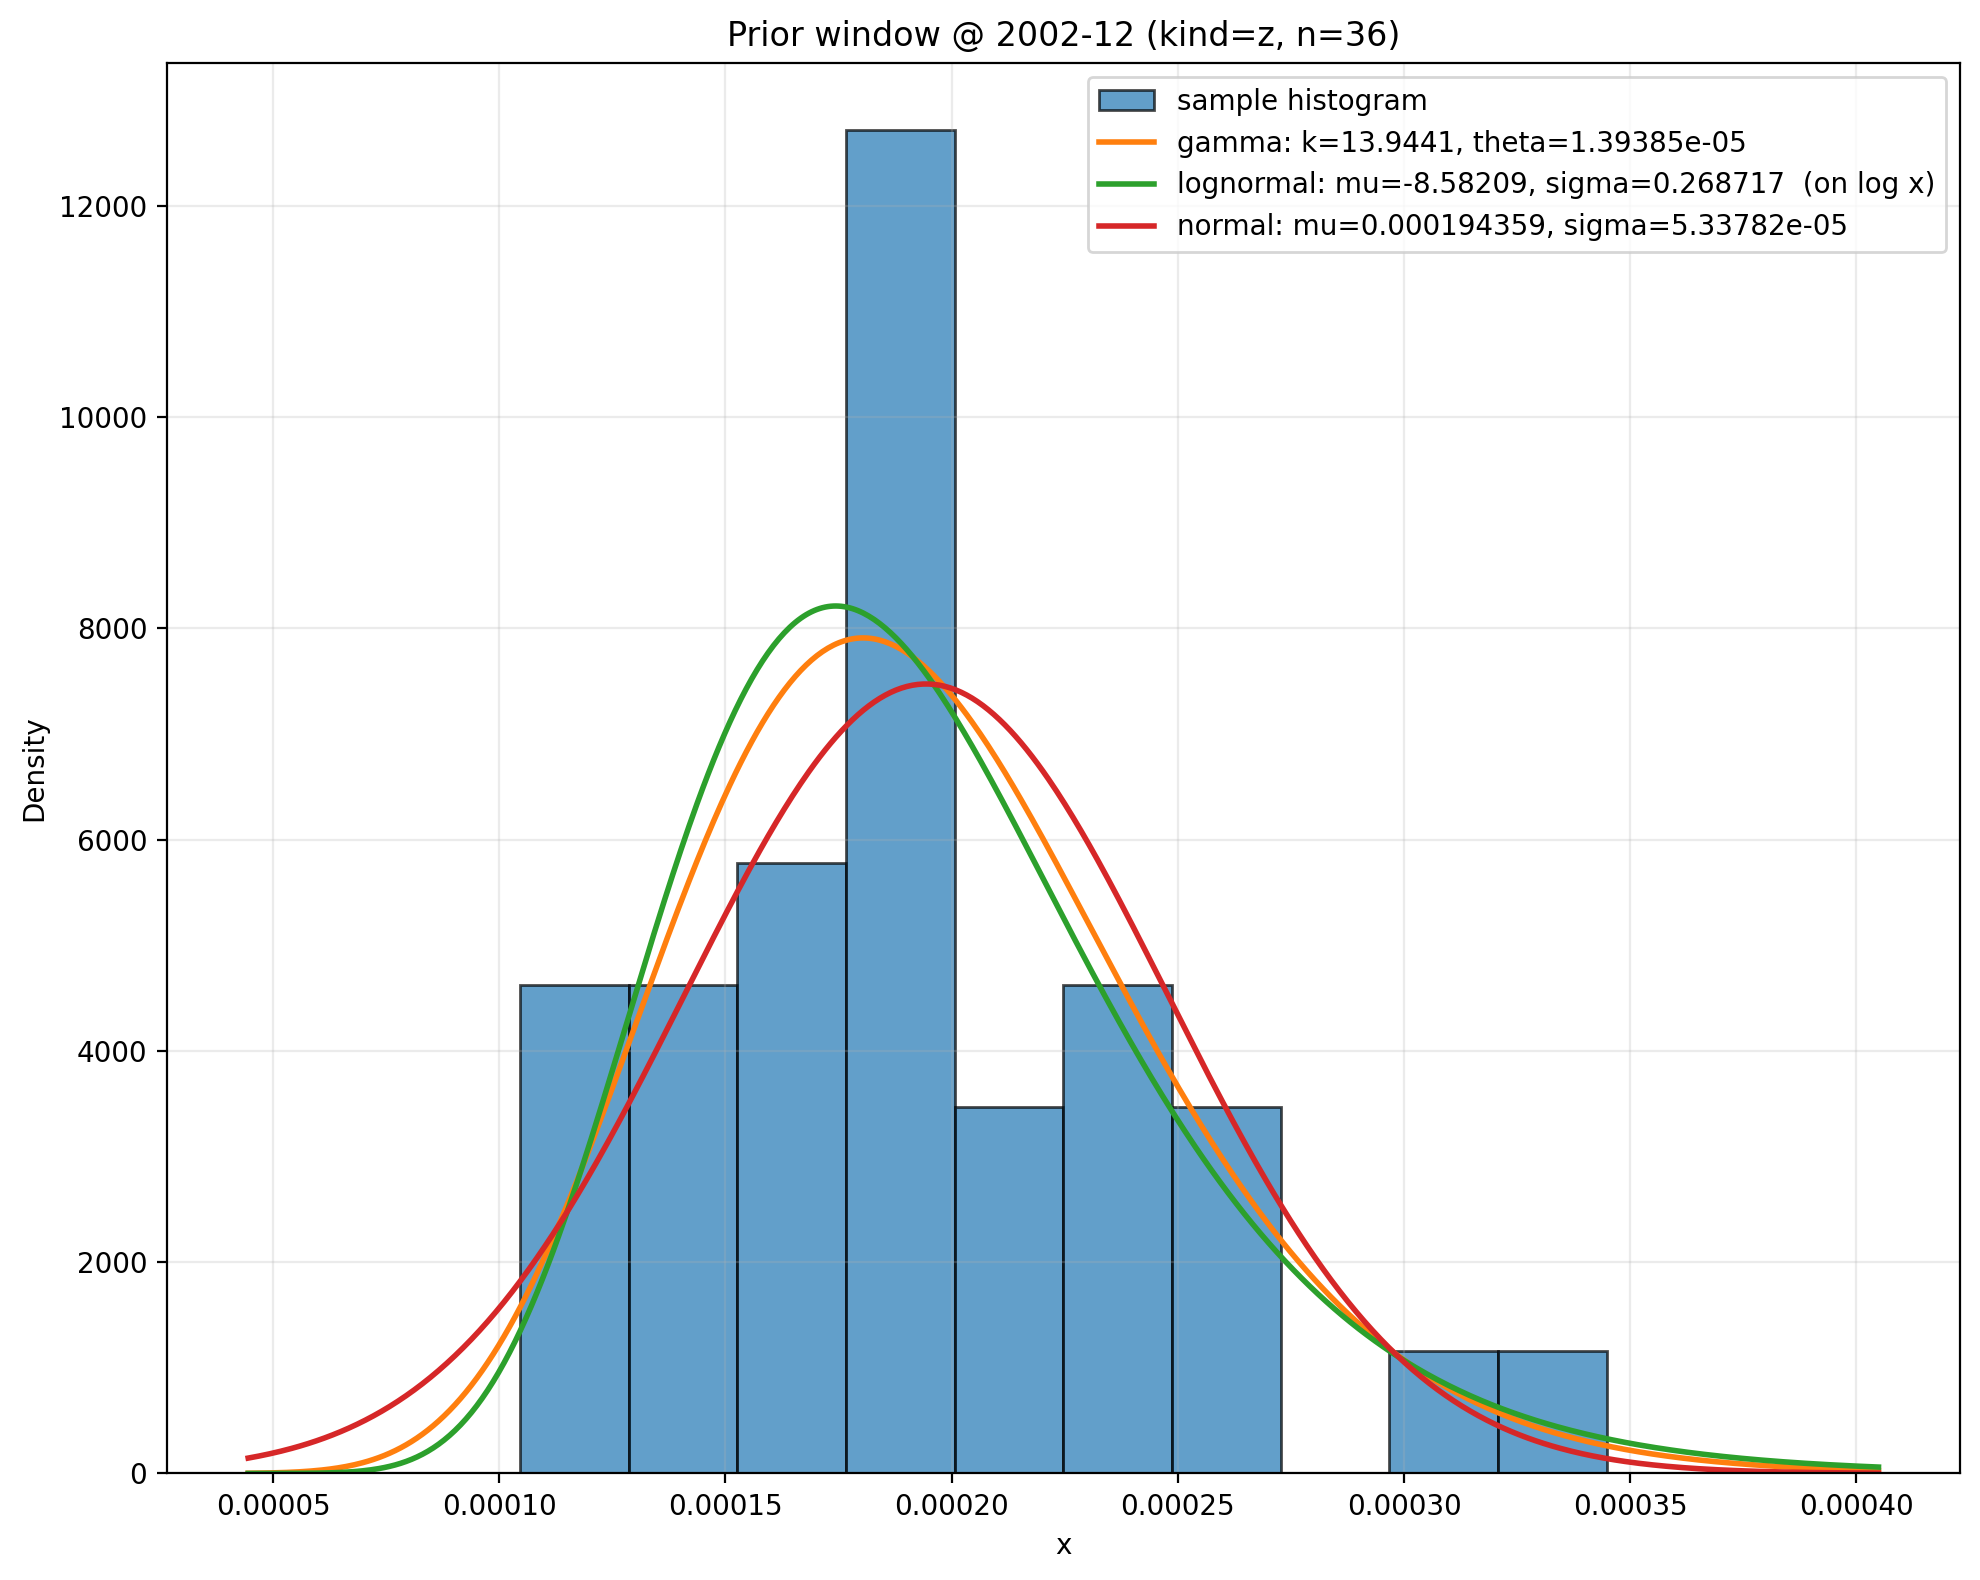

family     n   params                                   KS_D      KS_p      pass(p>0.05)
---------  --  ---------------------------------------  --------  --------  ------------
lognormal  36  mu=-8.58209, sigma=0.268717  (on log x)  0.101273  0.818143  OK          
gamma      36  k=13.9441, theta=1.39385e-05             0.119257  0.641865  OK          
normal     36  mu=0.000194359, sigma=5.33782e-05        0.155059  0.318544  OK          
Passed KS: lognormal, gamma, normal
Best: lognormal


In [6]:
# --- Prior diagnostic on SEED_PERIOD (hist+PDF only) --------------------------
# This uses the same internal fitting logic used by the rolling models.

seed_start, seed_end = SEED_PERIOD
ks_info = utils.plot_prior_from_window(
    rm,
    start_label=seed_start,
    end_label=seed_end,
    alpha=KS_ALPHA,
    save_fig=False,
    plot_ecdf=False,
    return_table=True,
)
plt.show()
print(ks_info["table"])
print("Passed KS:", ", ".join(ks_info["passed"]) if ks_info["passed"] else "(none)")
print("Best:", ks_info["best_name"])

In [7]:
# --- Run rolling experiment ---------------------------------------------------

res = rm.run()
steps = res.steps
print("Steps:", len(steps))
print("First step labels:", steps[0]["label_t"], "→", steps[0]["label_t1"])


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Steps: 64
First step labels: 2002-12 → 2003-01


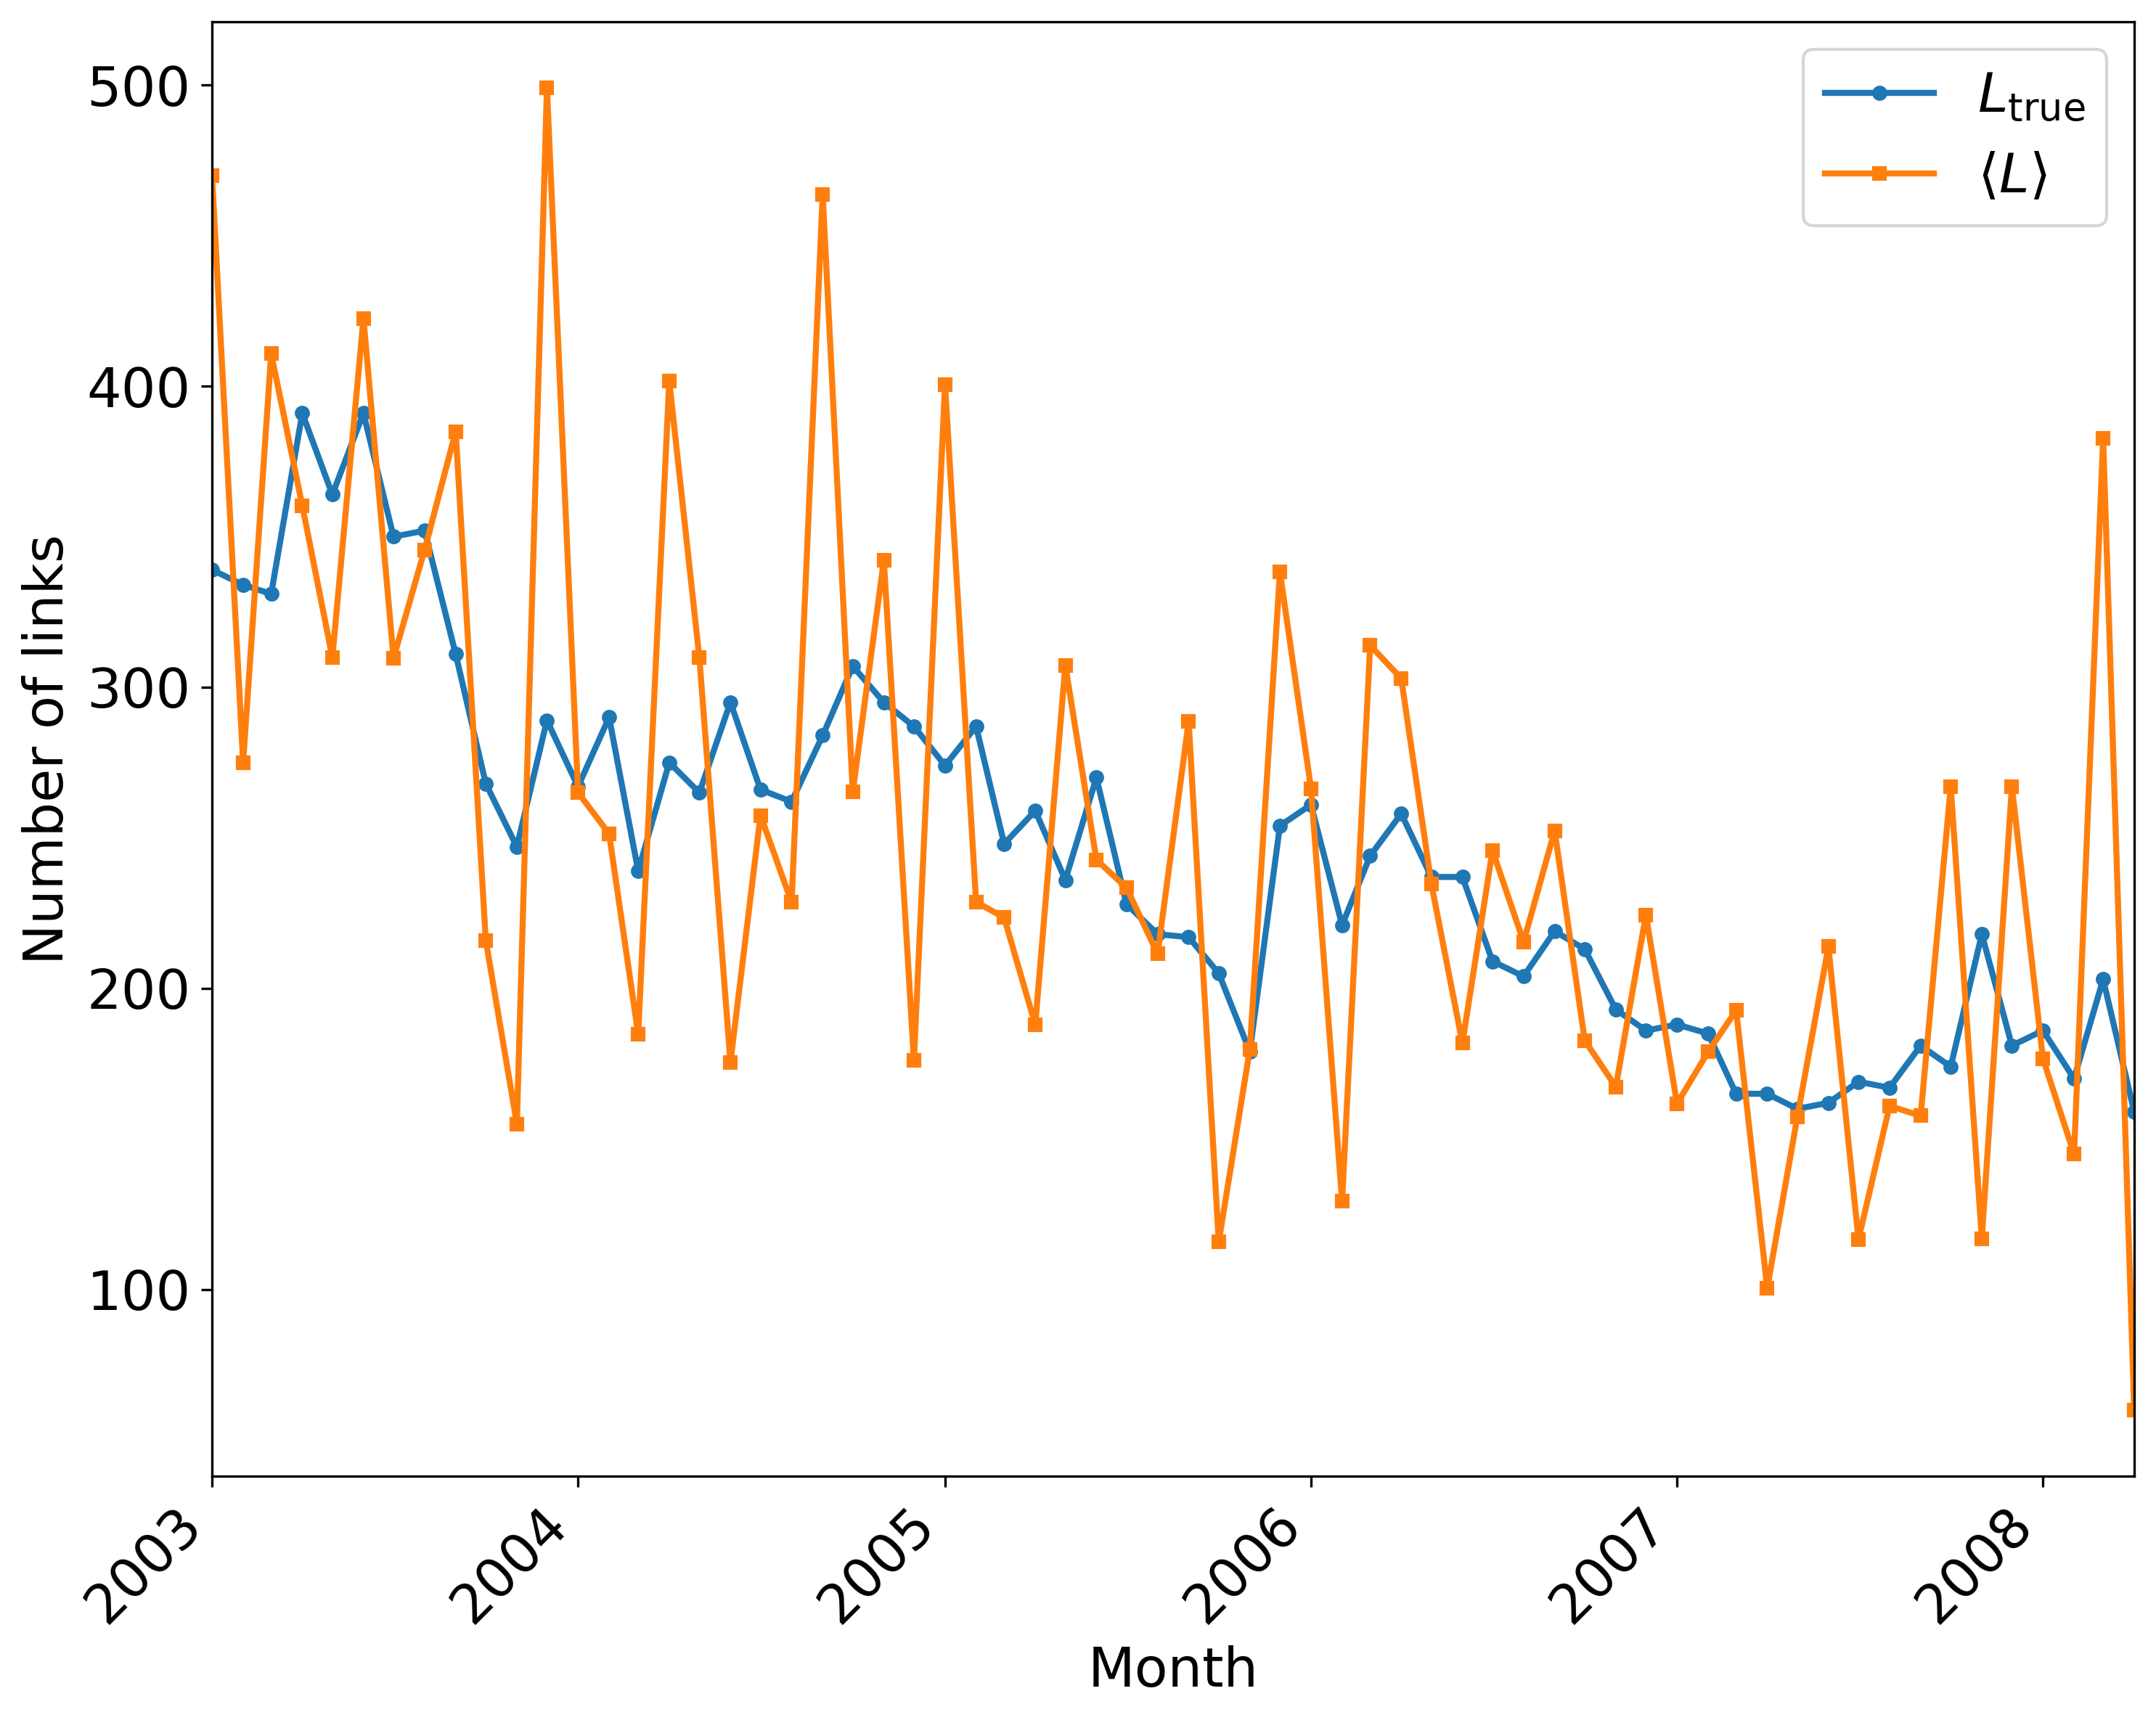

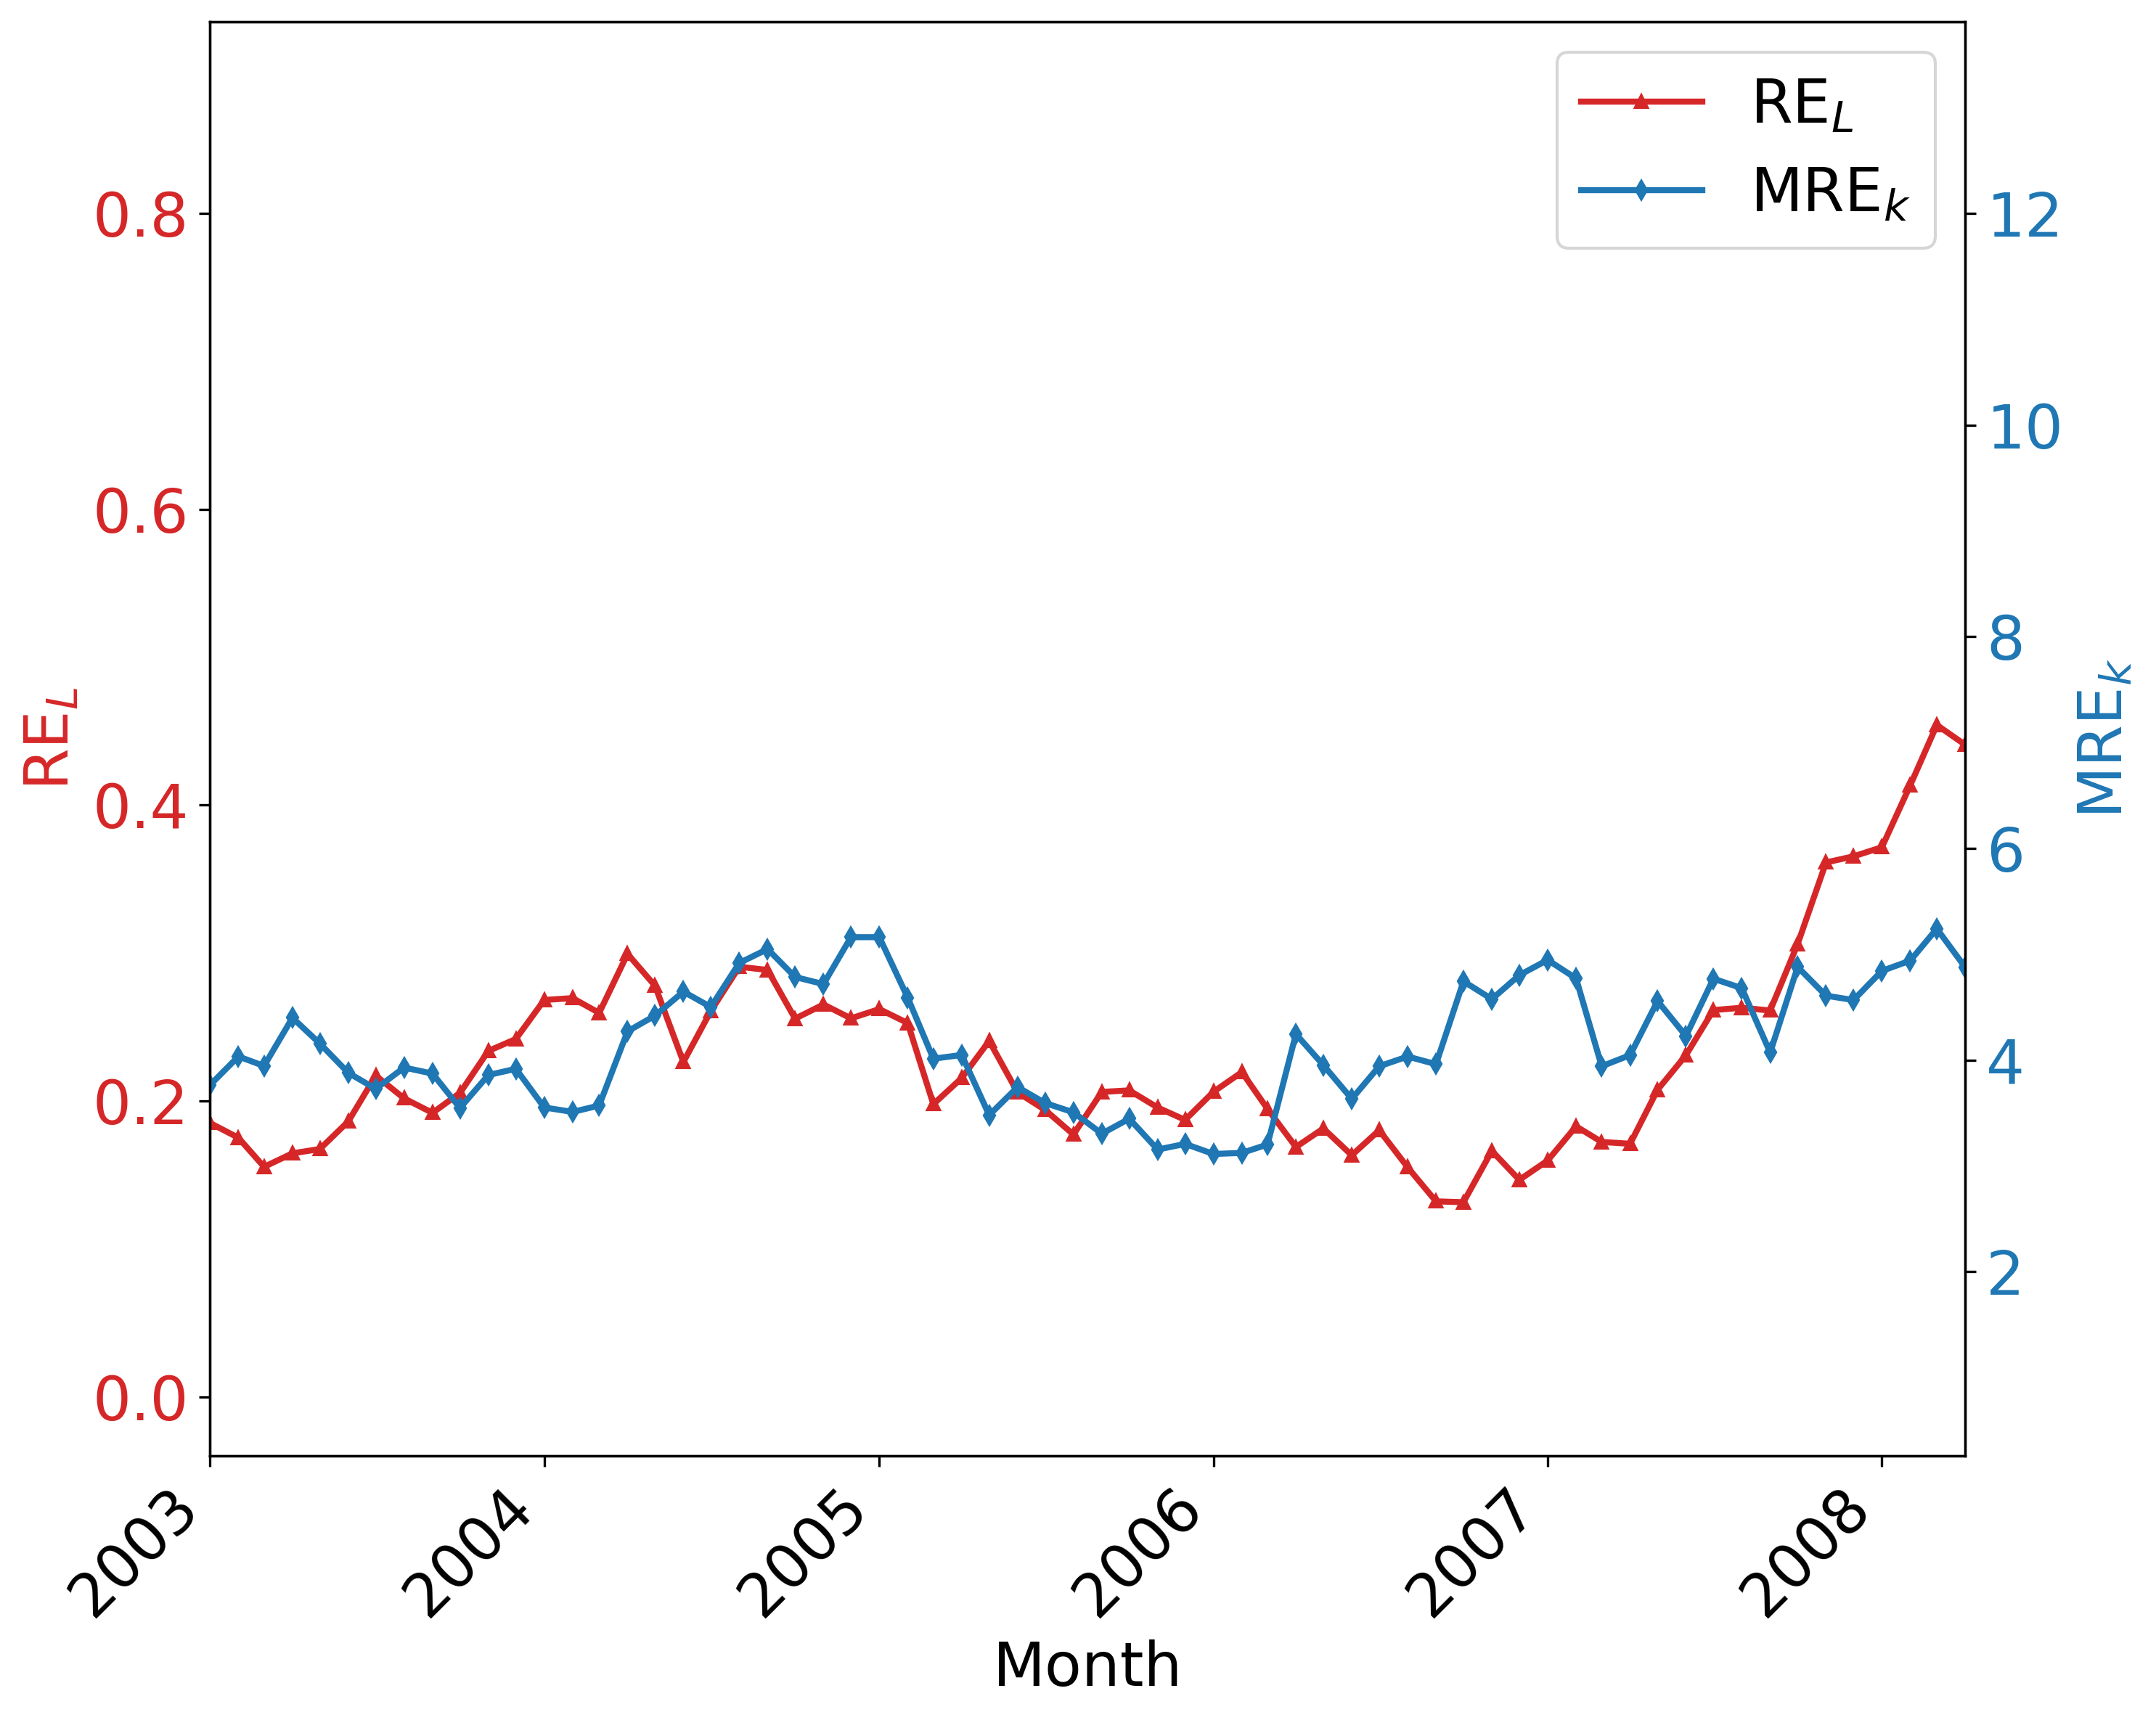

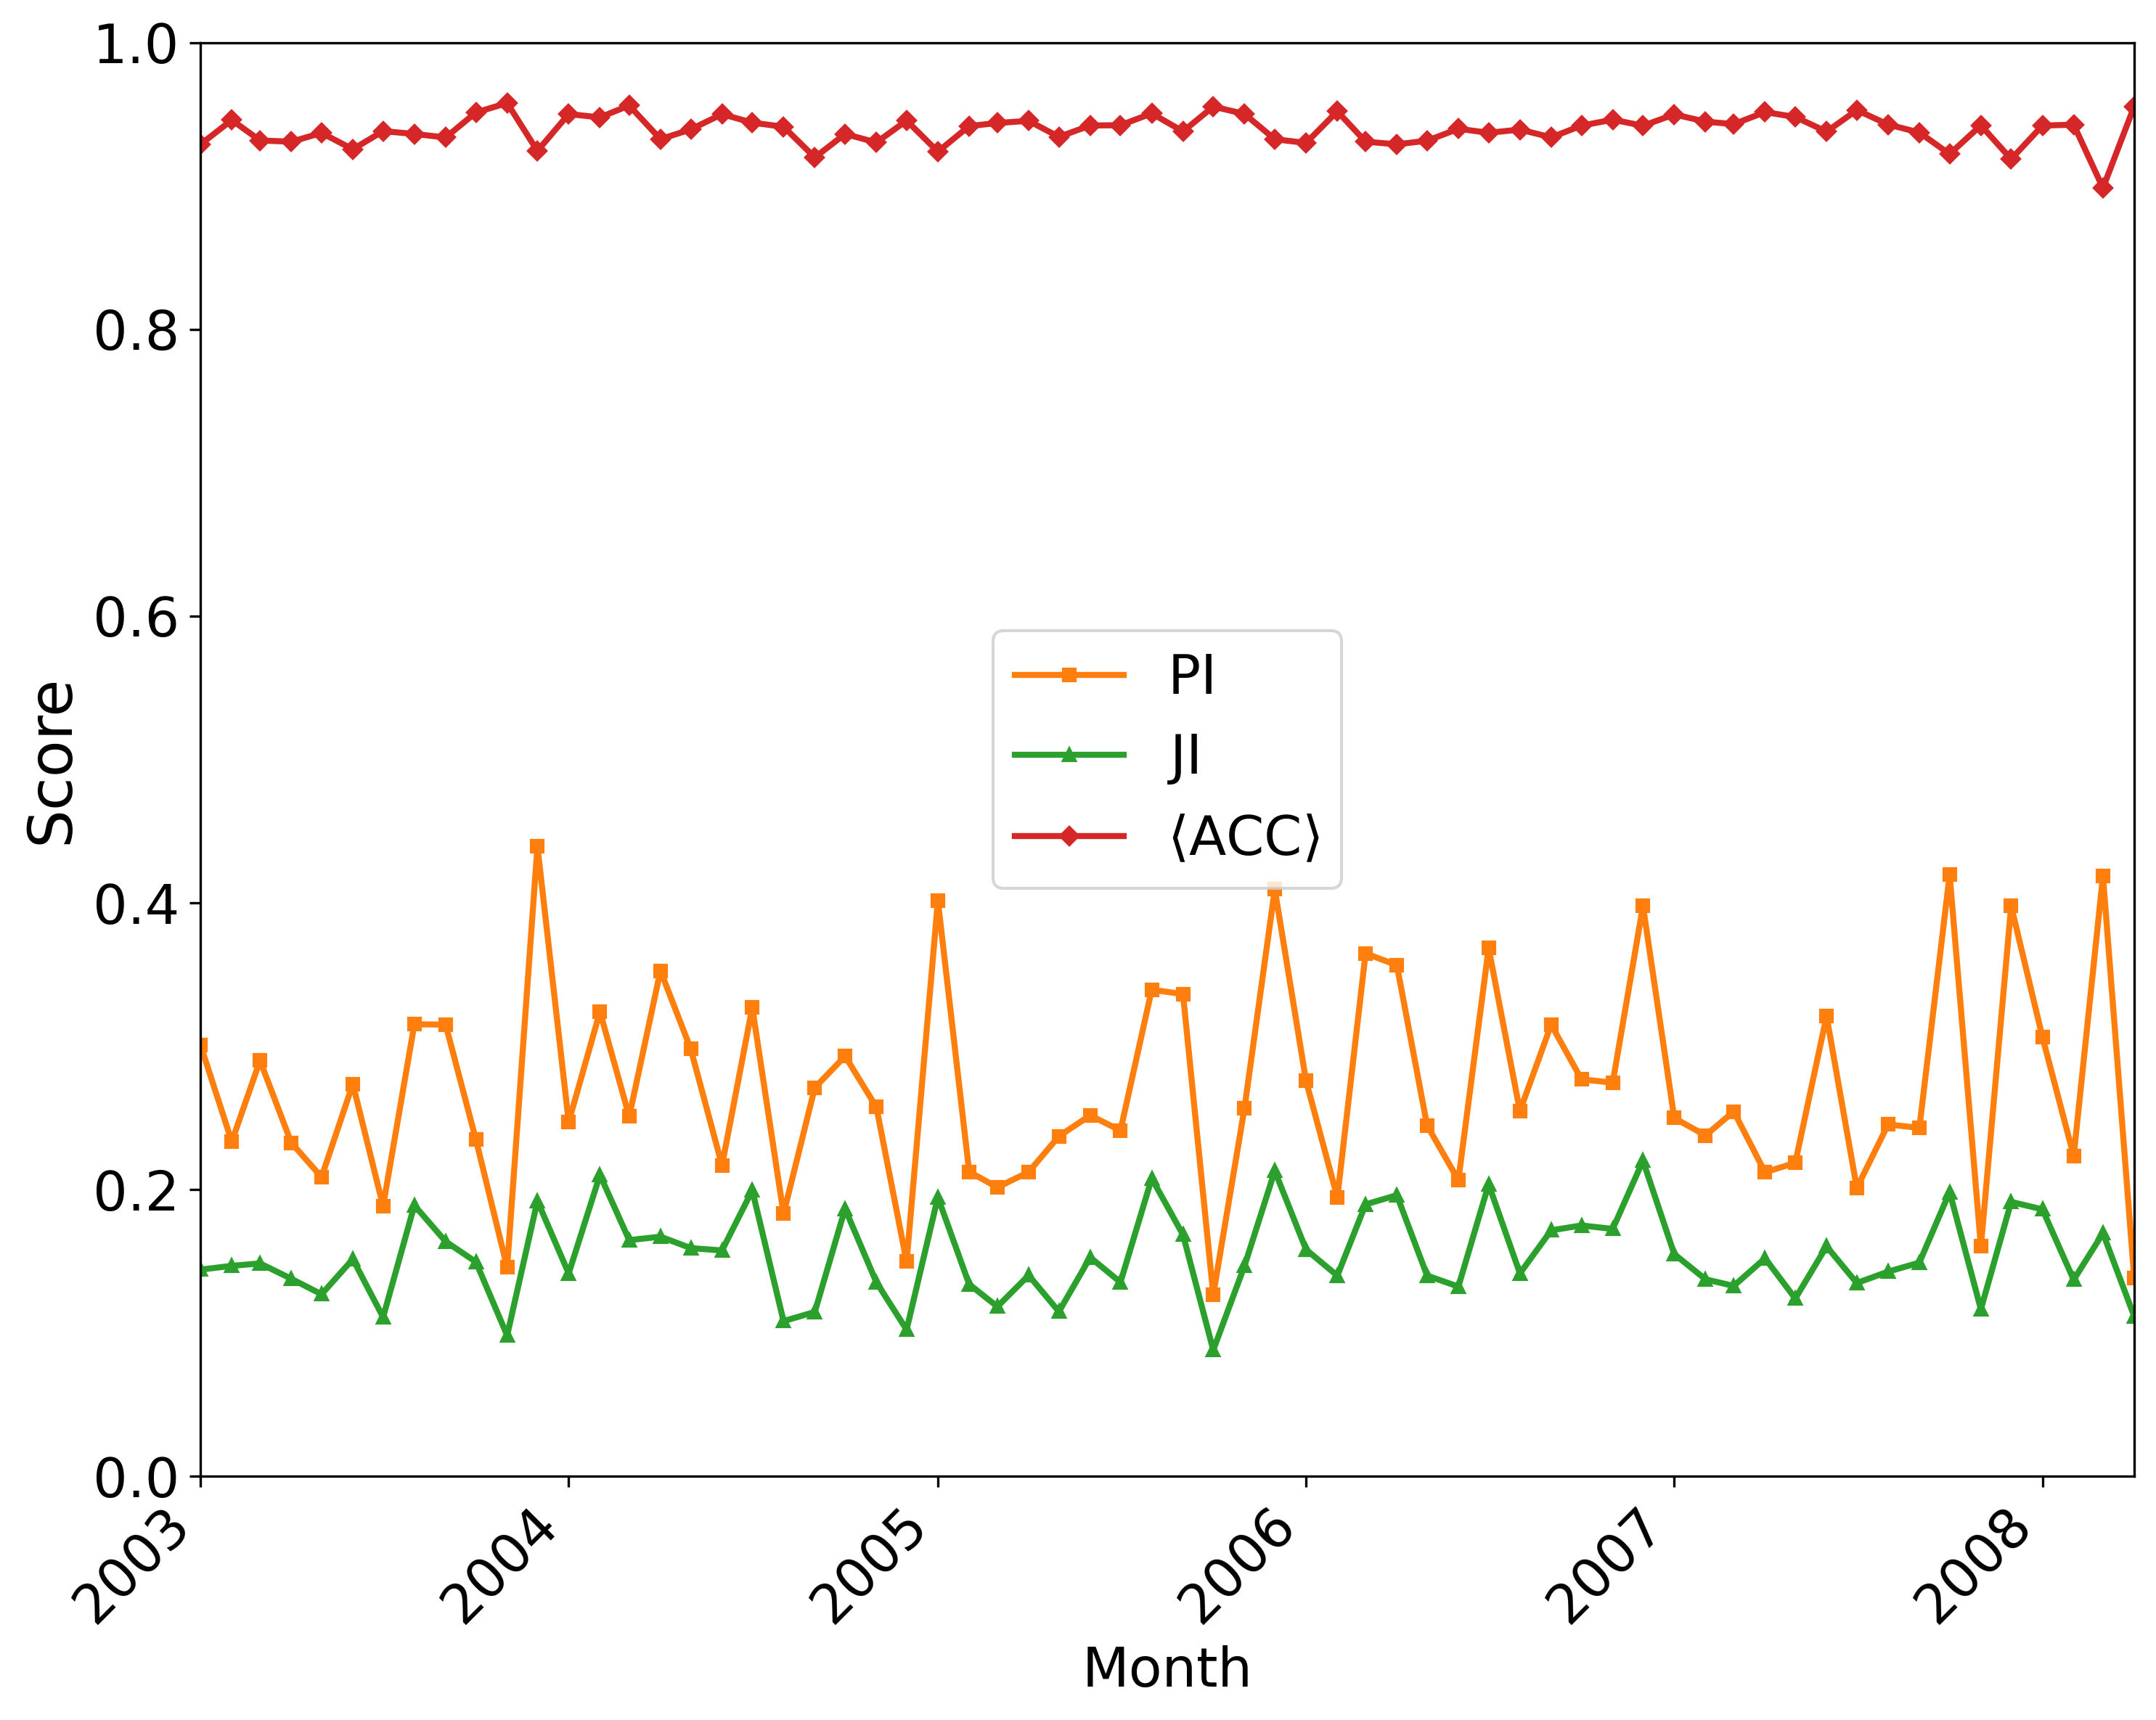

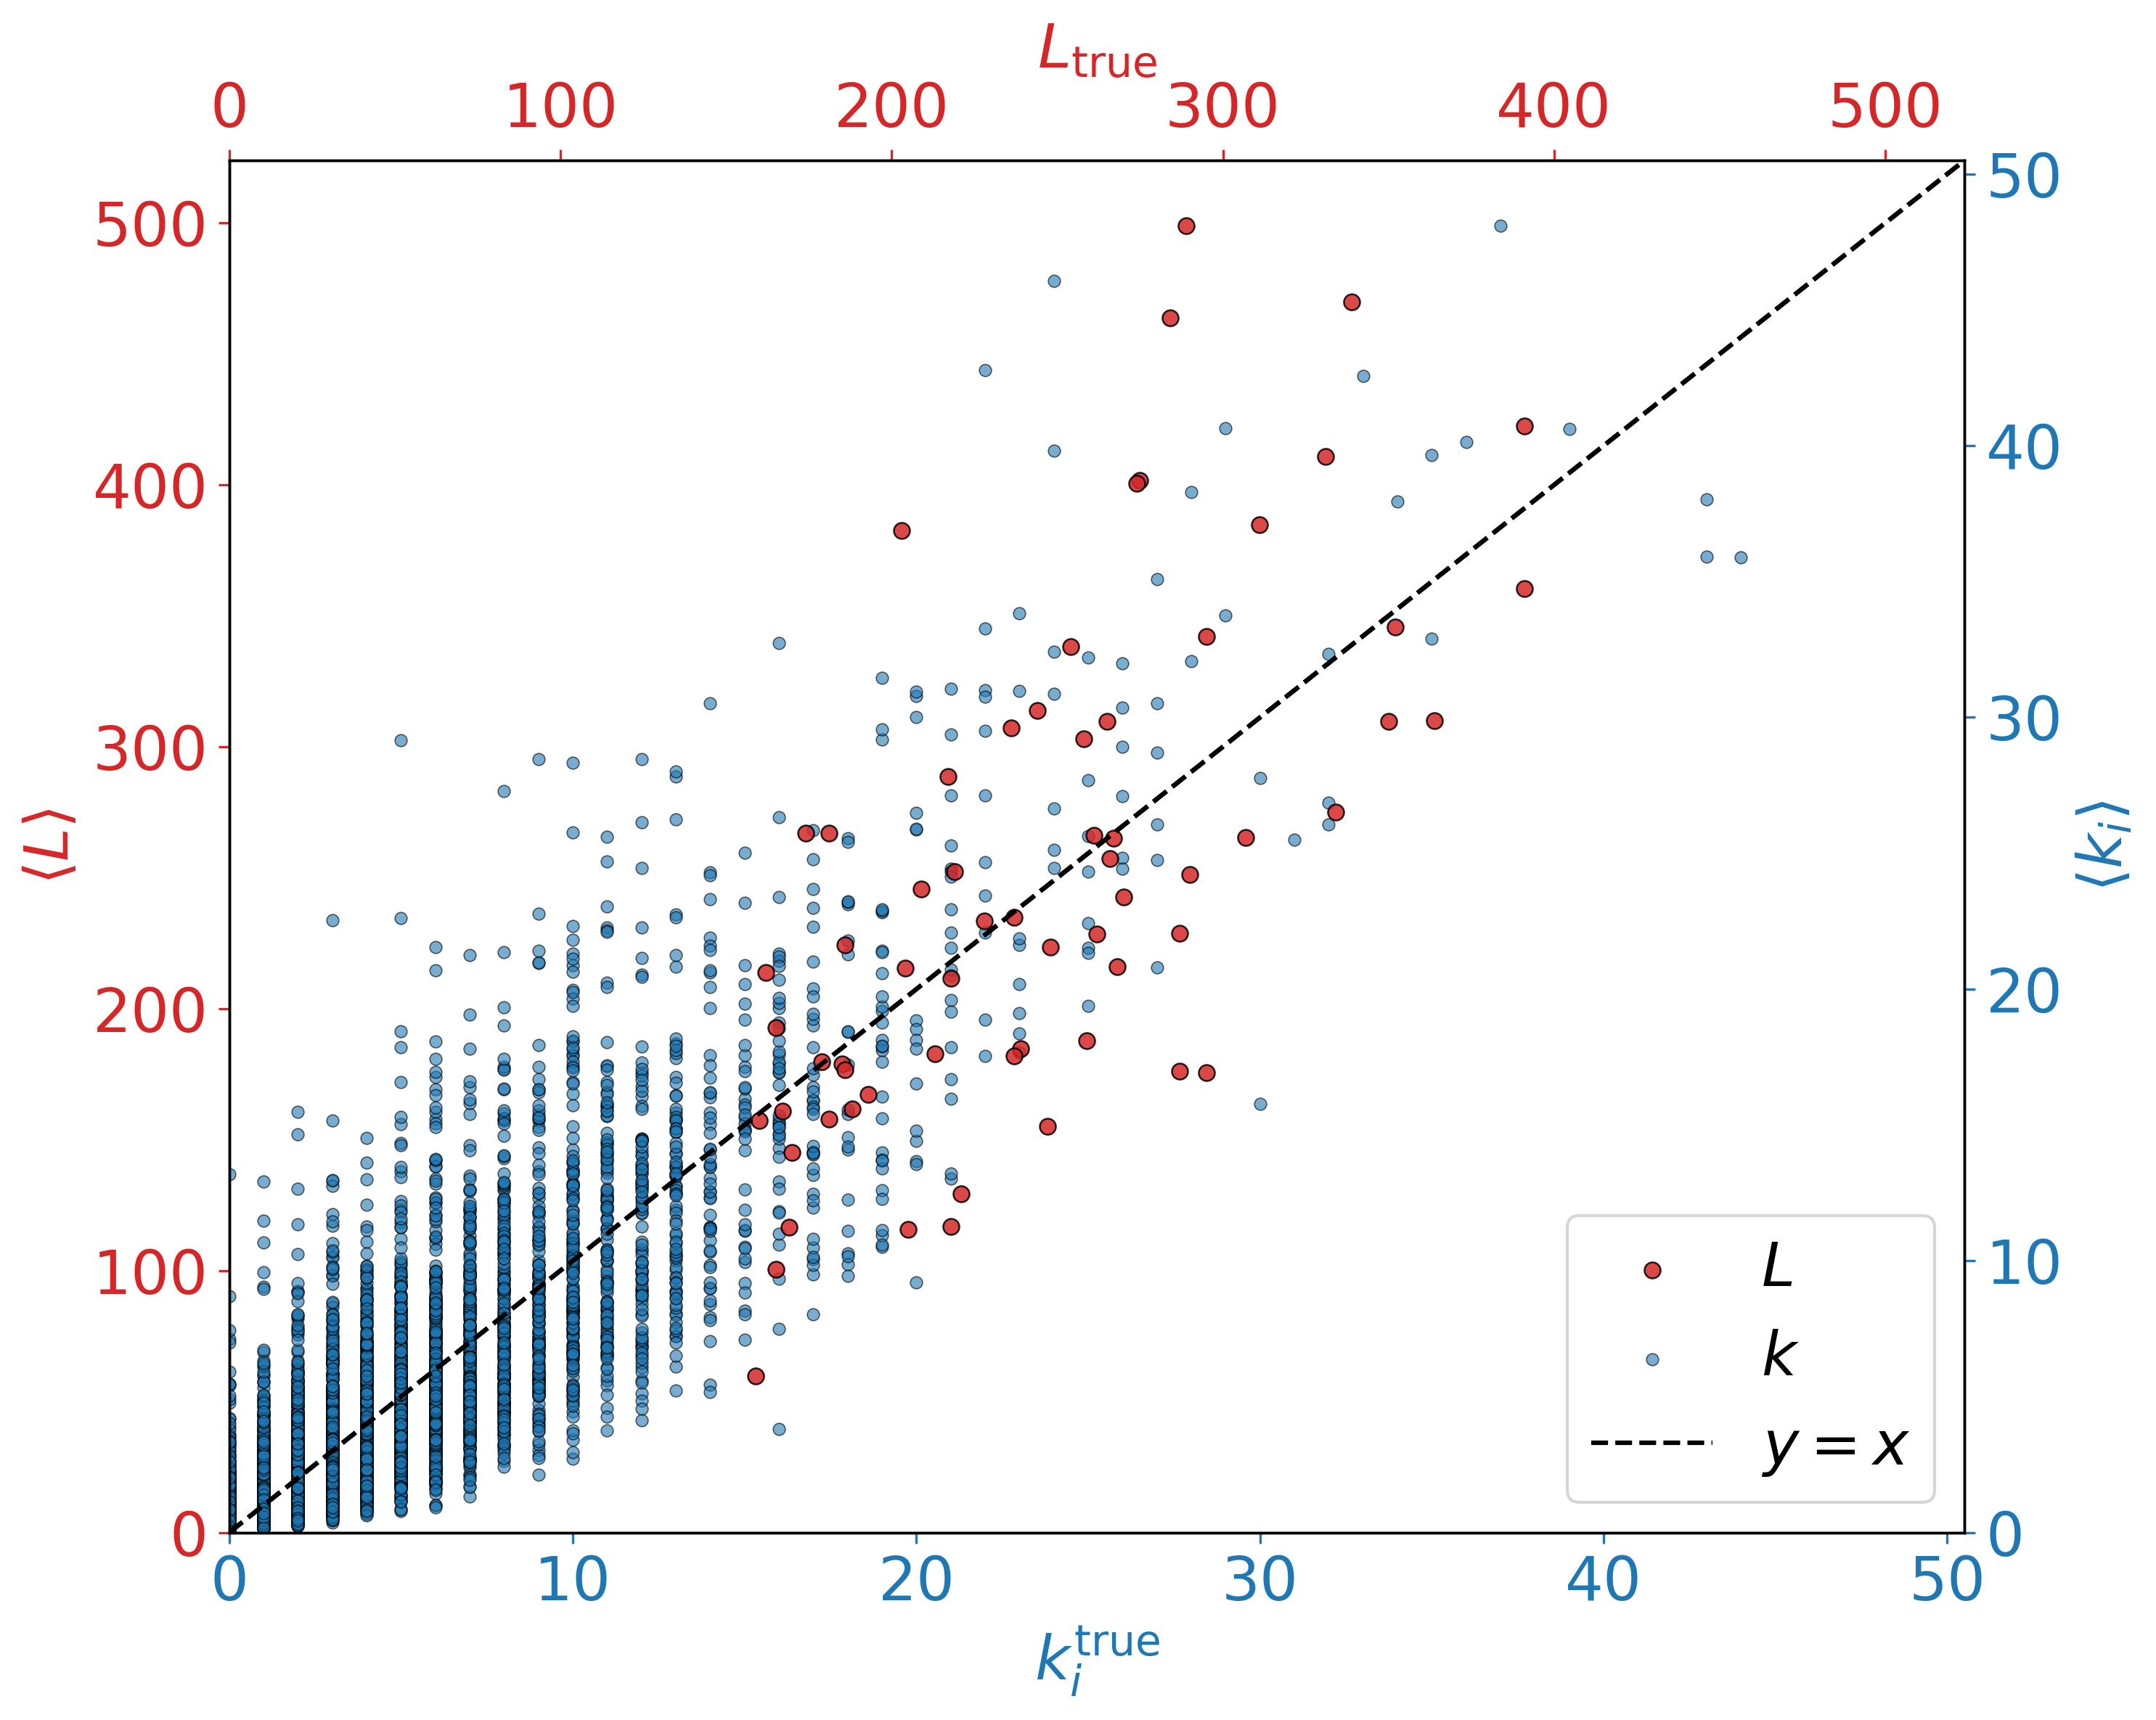

In [8]:
# --- Standard plots (shown only, no savefig) ---------------------------------

utils.plot_L_true_vs_Lhat(AGG, steps, save_fig=False)
plt.show()

utils.plot_errors_RE_L_and_MRE_k(AGG, steps, save_fig=False)
plt.show()

utils.plot_PI_JI_ACC(AGG, steps, save_fig=False)
plt.show()

# Parity plot for L and degrees (pooled by default)
utils.plot_parity_L_and_k(AGG, steps, mode="pooled", save_fig=False)
plt.show()
